In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sys,os
from statsmodels.stats.multitest import multipletests
from matplotlib.colors import ListedColormap as lcmap

from time import time
np.set_printoptions(precision=22)

#%precision 22
%matplotlib inline

In [2]:
from evaluate_results import read_results,calc_stats, plt_results,plot_stats_for_topN, find_diff

### TCGA-BRCA Lum vs Basal

* LumA is imbalanced 

### How many genes are DE?
* |log2(FC)| >1 and
* adj.pv <0.05

In [3]:
lfc_thr =1.0
adj_pv_thr = 0.05
table = pd.read_csv("TCGA-BRCA/balanced/results2/All.Rlimma_table.tsv",sep = "\t")
table = table.applymap(lambda x: np.float(x.replace(",",".")))
print("Total genes profiled:",table.shape[0])
d = table.loc[:,["adj.P.Val","logFC"]]
d = d.loc[d["adj.P.Val"]<adj_pv_thr,:]
print("DE based on p-val threhold:")
d_up = d.loc[d["logFC"] >0,:]
d_down = d.loc[d["logFC"] <0,:]
print("\t","upreg:",d_up.shape[0], "downreg:",d_down.shape[0], "total DE:", d_up.shape[0]+d_down.shape[0])
d_up = d.loc[d["logFC"] >=lfc_thr,:]
d_down = d.loc[d["logFC"] <=-lfc_thr,:]
n_DE_genes =  d_up.shape[0]+d_down.shape[0]
print("DE based on p-val and log2FC threholds:")
print("\t","upreg:",d_up.shape[0], "downreg:",d_down.shape[0], "total DE:", n_DE_genes)

Total genes profiled: 16927
DE based on p-val threhold:
	 upreg: 7211 downreg: 6746 total DE: 13957
DE based on p-val and log2FC threholds:
	 upreg: 1950 downreg: 1685 total DE: 3635


### Fig. S1A

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


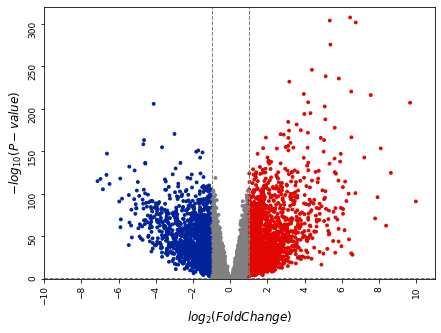

In [4]:
# from: https://reneshbedre.github.io/blog/volcano.html
from bioinfokit import analys, visuz

table["gene_names"] = table.index.values
gnames_to_plot = tuple(table.head(10).index.values)
offset = np.finfo(np.float).tiny
table_to_plot = table.copy()
table_to_plot.loc[table_to_plot["adj.P.Val"]==0,"adj.P.Val"] = offset

#ax=plt.figure(figsize=(7,5))
visuz.gene_exp.volcano( df=table_to_plot, lfc='logFC', pv='adj.P.Val', #
                       lfc_thr=1, pv_thr=0.05,
                       sign_line=True,
                       #genenames=gnames_to_plot ,geneid="gene_names",gstyle=1,
                       plotlegend=False, legendpos='upper center', 
                       figname = "../../paper_v1/Supplementary/Fig_S1A.Rlimma_volcano",figtype="png",
                       show=True,
                       axlabelfontsize=12,
                       xlm=(-10,11,2),ylm = (0,320,50),
                       color=("#E10600FF", "grey","#00239CFF" ),dim=(7,5))
#ax.text(-9,300,"A", fontsize=24)

In [5]:
root_dir = "TCGA-BRCA/"
dfs = {}
workdir = root_dir + "mild_imbalance/results2/"
df = read_results(workdir)
dfs["Mild Imbalance"]  =df
workdir = root_dir + "balanced/results2/"
df = read_results(workdir)
dfs["Balance"]  =df
workdir = root_dir + "strong_imbalance/results2/"
df = read_results(workdir)
dfs["Strong Imbalance"]  =df
df.head(3)

,pv_Rlimma,lfc_Rlimma,lfc_Fisher,pv_Fisher,lfc_REM,pv_REM,pv_Flimma,lfc_Flimma,pv_Stouffer,lfc_Stouffer,pv_RankProd,lfc_RankProd
100133144,1.416963,-0.294186,-0.111089,0.606262,-0.196106,0.377853,1.416949,-0.294185,0.013890,-0.111089,0.318956,-0.111089
100134869,3.715913,-0.386904,-0.276076,1.558590,-0.328195,2.204507,3.715253,-0.386861,0.922378,-0.276076,0.457320,-0.276076
10357,19.315527,-0.472955,-0.476161,13.357015,-0.471705,15.373966,19.314601,-0.472942,12.739948,-0.476161,0.701874,-0.476161


In [6]:
colors = ["#000000","#E69F00", "#CC79A7", "#009E73","#56B4E9"]

### Fig 3A

Balance                      Mild Imbalance                       \
                 r         ρ       RMSE              r         ρ       RMSE   
Flimma    1.000000  1.000000   0.001133       1.000000  1.000000   0.001089   
Fisher    0.999593  0.994831   1.251514       0.998883  0.992636   1.919021   
Stouffer  0.999739  0.990891   0.984039       0.996476  0.984942   4.920806   
REM       0.931303  0.969175  10.114329       0.869761  0.926591  13.227222   
RankProd  0.712206  0.849627  28.786071       0.709313  0.826997  28.954294   

         Strong Imbalance                       
                        r         ρ       RMSE  
Flimma           1.000000  1.000000   0.000914  
Fisher           0.993672  0.980946   6.655289  
Stouffer         0.992961  0.974215   8.864671  
REM              0.828080  0.884873  15.153918  
RankProd         0.714621  0.827121  29.174152

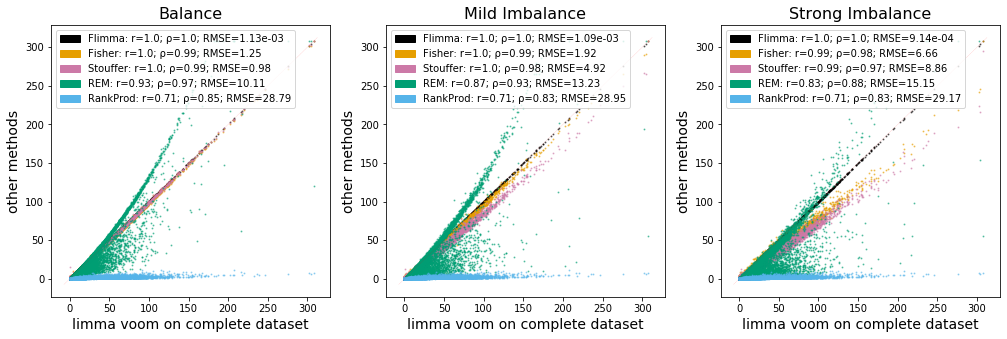

In [7]:
corrs = plt_results(dfs, text = "",colors=colors)
plt.savefig("../../paper_v1/Fig3A_Performace_TCGA.svg")
plt.savefig("../../paper_v1/Fig3A_Performace_TCGA.png")
corrs

In [8]:
stats = {}
for m in ["TP","FP","FN"]:
    for ds in ["Balance","Mild Imbalance","Strong Imbalance"]:
        df = dfs[ds].sort_values(by="pv_Rlimma",ascending = False)
        results = calc_stats(df,lfc_thr=1,adj_pval_thr = -np.log10(0.05),
                                                        methods=["Flimma","Fisher","Stouffer","REM","RankProd"])
        stats[(m,ds)] = results[m]
    
    #print(confusion_matrix)
pd.DataFrame.from_dict(stats)

TP                                      FP                 \
         Balance Mild Imbalance Strong Imbalance Balance Mild Imbalance   
Flimma    3586.0         3515.0           3271.0     0.0            0.0   
Fisher    3578.0         3225.0           3006.0    14.0          248.0   
Stouffer  3577.0         3225.0           3006.0    14.0          245.0   
REM       3569.0         3396.0           3056.0    12.0           80.0   
RankProd  3574.0         3220.0           2997.0    14.0          243.0   

                               FN                                  
         Strong Imbalance Balance Mild Imbalance Strong Imbalance  
Flimma                0.0     0.0            0.0              0.0  
Fisher              192.0     8.0          290.0            265.0  
Stouffer            189.0     9.0          290.0            265.0  
REM                 121.0    17.0          119.0            215.0  
RankProd            193.0    12.0          295.0            274.0

In [9]:

stats2 = find_diff(dfs)
stats2 = stats2.loc[["Balance","Mild Imbalance","Strong Imbalance"],:]
stats2.style.format("{:.2e}") 

In [10]:
stats = {}
for m in ["FP","FN","Precision","Recall","F1"]:
    for ds in ["Balance","Mild Imbalance","Strong Imbalance"]:
        df = dfs[ds].sort_values(by="pv_Rlimma",ascending = False)
        results = calc_stats(df,lfc_thr=1,adj_pval_thr = -np.log10(0.05),
                                                        methods=["Flimma","Fisher","Stouffer","REM","RankProd"])
        stats[(m,ds)] = results[m]
    
    #print(confusion_matrix)
pd.DataFrame.from_dict(stats)

FP                                      FN                 \
         Balance Mild Imbalance Strong Imbalance Balance Mild Imbalance   
Flimma       0.0            0.0              0.0     0.0            0.0   
Fisher      14.0          248.0            192.0     8.0          290.0   
Stouffer    14.0          245.0            189.0     9.0          290.0   
REM         12.0           80.0            121.0    17.0          119.0   
RankProd    14.0          243.0            193.0    12.0          295.0   

                          Precision                                    Recall  \
         Strong Imbalance   Balance Mild Imbalance Strong Imbalance   Balance   
Flimma                0.0  1.000000       1.000000         1.000000  1.000000   
Fisher              265.0  0.996102       0.928592         0.939962  0.997769   
Stouffer            265.0  0.996101       0.929395         0.940845  0.997490   
REM                 215.0  0.996649       0.976985         0.961914  0.995259   
RankProd            274.0  0.996098       0.929830         0.939498  0.996654   

                                                F1                 \
         Mild Imbalance Strong Imbalance   Balance Mild Imbalance   
Flimma         1.000000         1.000000  1.000000       1.000000   
Fisher         0.917496         0.918985  0.996935       0.923011   
Stouffer       0.917496         0.918985  0.996795       0.923407   
REM            0.966145         0.934271  0.995954       0.971535   
RankProd       0.916074         0.916234  0.996376       0.922901   

                           
         Strong Imbalance  
Flimma           1.000000  
Fisher           0.929355  
Stouffer         0.929787  
REM              0.947891  
RankProd         0.927720

In [11]:
stats = {}
for m in ["RMSE","r","ρ"]:
    for ds in ["Balance","Mild Imbalance","Strong Imbalance"]:
        df = dfs[ds].sort_values(by="pv_Rlimma",ascending = False)
        results = calc_stats(df,lfc_thr=1,adj_pval_thr = -np.log10(0.05),
                                                        methods=["Flimma","Fisher","Stouffer","REM","RankProd"])
        stats[(m,ds)] = results[m]
    
    #print(confusion_matrix)
pd.DataFrame.from_dict(stats)

RMSE                                         r                 \
            Balance Mild Imbalance Strong Imbalance   Balance Mild Imbalance   
Flimma     0.001133       0.001089         0.000914  1.000000       1.000000   
Fisher     1.251514       1.919021         6.655289  0.999593       0.998883   
Stouffer   0.984039       4.920806         8.864671  0.999739       0.996476   
REM       10.114329      13.227222        15.153918  0.931303       0.869761   
RankProd  28.786071      28.954294        29.174152  0.712206       0.709313   

                                  ρ                                  
         Strong Imbalance   Balance Mild Imbalance Strong Imbalance  
Flimma           1.000000  1.000000       1.000000         1.000000  
Fisher           0.993672  0.994831       0.992636         0.980946  
Stouffer         0.992961  0.990891       0.984942         0.974215  
REM              0.828080  0.969175       0.926591         0.884873  
RankProd         0.714621  0.849627       0.826997         0.827121

### Fig 4A

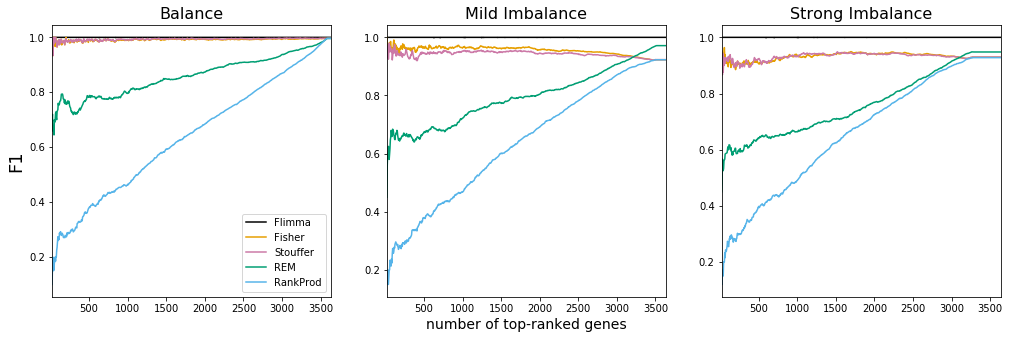

In [12]:
min_n_genes = 20
step = 5
max_n_genes = n_DE_genes+step

tmp = plot_stats_for_topN(dfs,metrics=["F1"],log=False,min_n_genes=min_n_genes,
                          max_n_genes = max_n_genes,step=step,text="",colors=colors,
                         figfile= "../../paper_v1/Fig4A_F1_TCGA.svg")

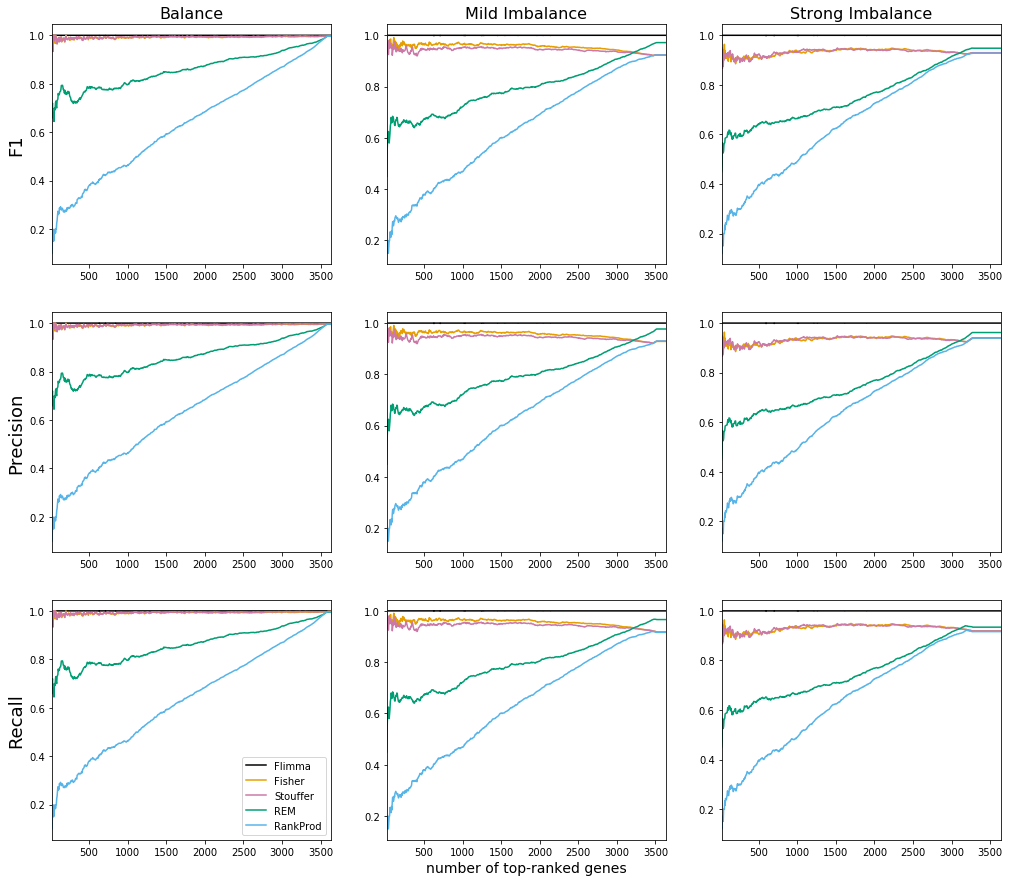

In [14]:
data = plot_stats_for_topN(dfs,metrics=["F1","Precision","Recall"],min_n_genes=min_n_genes,
                            max_n_genes = max_n_genes, step=step,colors=colors)

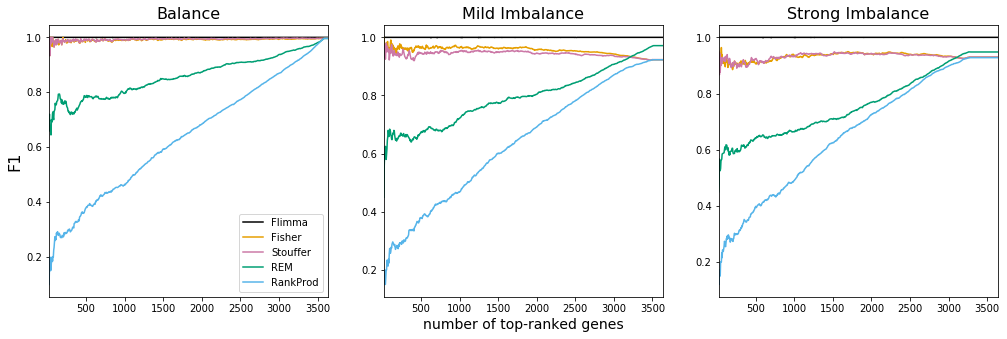

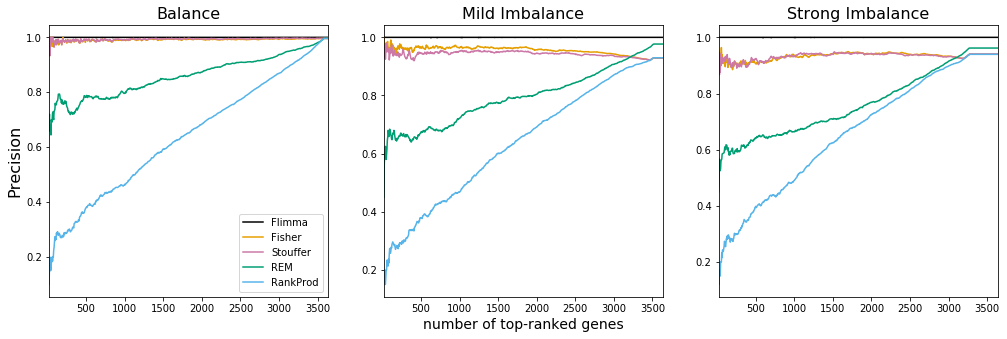

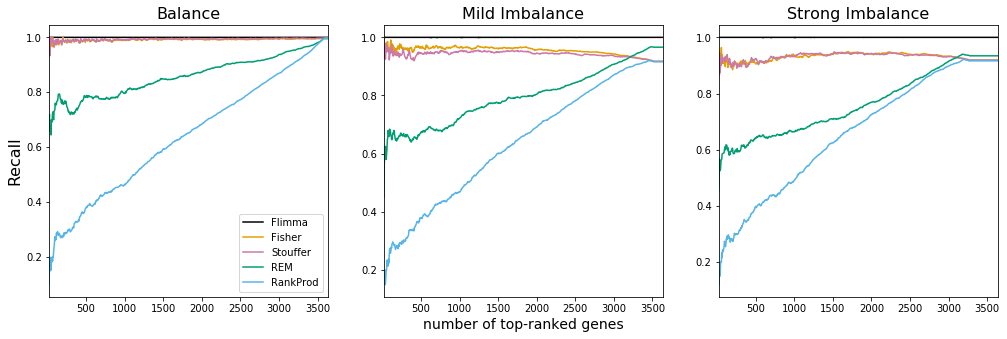

In [13]:
data = {}
for metric in ["F1","Precision","Recall"]:
    tmp = plot_stats_for_topN(dfs,what=metric,log=False,min_n_genes=min_n_genes,
                          max_n_genes = max_n_genes,step=step,text="",colors=colors)

### Fig. S2 Correlation and RMSE

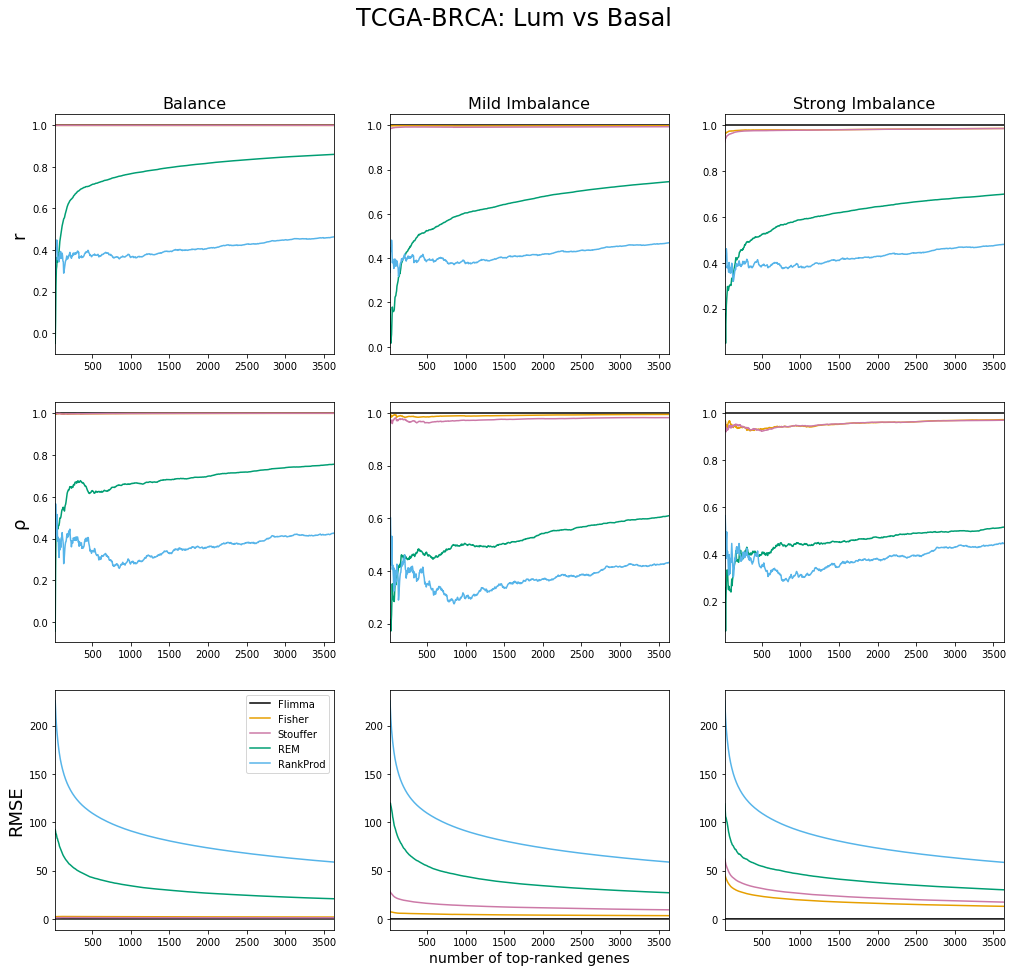

In [13]:
data = plot_stats_for_topN(dfs,metrics=["r","ρ","RMSE"],min_n_genes=min_n_genes,
                            max_n_genes = max_n_genes, step=step,colors=colors,
                            suptitle = "TCGA-BRCA: Lum vs Basal",
                            figfile="../../paper_v1/Supplementary/FigS2_RMSE_corr_TCGA.png")

# TCGA-BRCA split by tissue source sites


In [39]:
tcga_cohorts = {}
dfs = {}
for n in [3,5,7,10,14]:#
    workdir = root_dir + "/TCGA_real_"+str(n)+"_cohorts/results/"
    df = read_results(workdir)
    d = pd.read_csv(root_dir + "/TCGA_real_"+str(n)+"_cohorts/"+"/All.design.tsv",sep="\t",index_col=0)
    print(n,"cohorts",d.shape[0],"samples")
    df = df.sort_values(by="pv_Rlimma",ascending = False)
    dfs[str(n)+" cohorts\n"+str(d.shape[0])+"samples"] = df
    stats =  calc_stats(df,lfc_thr=1.0,adj_pval_thr = -np.log10(0.05))
    tcga_cohorts[str(n)+" cohorts\n"+str(d.shape[0])+"samples"] = stats


3 cohorts 199 samples
5 cohorts 295 samples
7 cohorts 383 samples
10 cohorts 592 samples
14 cohorts 733 samples


In [29]:
stats = {}
for m in ["FP","FN"]: # , 
    for ds in tcga_cohorts.keys():
        stats[(m,ds)] = tcga_cohorts[ds][m]
    
pd.DataFrame.from_dict(stats)



FP                                              \
         3 cohorts\n199samples 5 cohorts\n295samples 7 cohorts\n383samples   
flimma                     0.0                   1.0                   0.0   
Fisher                   600.0                 452.0                 352.0   
Stouffer                 565.0                 425.0                 335.0   
REM                      252.0                 232.0                 178.0   
RankProd                 290.0                 505.0                 381.0   

                                                                          FN  \
         10 cohorts\n592samples 14 cohorts\n733samples 3 cohorts\n199samples   
flimma                      0.0                    0.0                   0.0   
Fisher                    255.0                  188.0                 298.0   
Stouffer                  250.0                  177.0                 389.0   
REM                       119.0                  102.0                 260.0   
RankProd                  265.0                  190.0                 473.0   

                                                                             \
         5 cohorts\n295samples 7 cohorts\n383samples 10 cohorts\n592samples   
flimma                     0.0                   0.0                    0.0   
Fisher                   189.0                 174.0                  138.0   
Stouffer                 245.0                 212.0                  152.0   
REM                      130.0                 109.0                   72.0   
RankProd                 136.0                 137.0                  130.0   

                                 
         14 cohorts\n733samples  
flimma                      0.0  
Fisher                    108.0  
Stouffer                  118.0  
REM                        85.0  
RankProd                  102.0

In [40]:
stats2 = find_diff(dfs)
stats2 = stats2.loc[list(dfs.keys()),:]
stats2.style.format("{:.2e}") 

In [15]:
stats = {}
for m in ["Precision","Recall","F1"]: # "Precision","Recall","F1", 
    for ds in tcga_cohorts.keys():
        stats[(m,ds.split()[0])] = tcga_cohorts[ds][m]
    
pd.DataFrame.from_dict(stats)


Precision                                            Recall  \
                 3         5         7        10        14         3   
flimma    1.000000  0.999712  1.000000  1.000000  1.000000  1.000000   
Fisher    0.847947  0.878885  0.904813  0.930442  0.948380  0.918222   
Stouffer  0.852094  0.883530  0.908043  0.931451  0.951118  0.893249   
REM       0.930693  0.935032  0.950404  0.966908  0.971500  0.928650   
RankProd  0.916209  0.868421  0.898778  0.928067  0.947945  0.870198   

                                                        F1            \
                 5         7        10        14         3         5   
flimma    1.000000  1.000000  1.000000  1.000000  1.000000  0.999856   
Fisher    0.945517  0.950568  0.961116  0.969680  0.881686  0.910985   
Stouffer  0.929374  0.939773  0.957171  0.966873  0.872186  0.905872   
REM       0.962525  0.969034  0.979713  0.976137  0.929670  0.948580   
RankProd  0.960796  0.961080  0.963370  0.971364  0.892611  0.912276   

                                        
                 7        10        14  
flimma    1.000000  1.000000  1.000000  
Fisher    0.927127  0.945530  0.958912  
Stouffer  0.923635  0.944136  0.958931  
REM       0.959629  0.973268  0.973813  
RankProd  0.928885  0.945389  0.959512

In [16]:
stats = {}
for m in ["RMSE","r","ρ"]: # "Precision","Recall","F1", 
    for ds in tcga_cohorts.keys():
        stats[(m,ds.split()[0])] = tcga_cohorts[ds][m]
    
pd.DataFrame.from_dict(stats)

RMSE                                                    r  \
                 3         5          7         10         14         3   
flimma    0.000769  0.000654   0.000758   0.001701   0.001177  1.000000   
Fisher    0.937239  1.817055   2.529657   3.859960   5.365320  0.989711   
Stouffer  1.474583  2.212446   2.870905   4.255903   5.676461  0.979470   
REM       2.734581  3.678333   4.745020   7.206078   8.497715  0.854559   
RankProd  5.156973  8.193738  11.317147  18.924760  23.497736  0.694072   

                                                         ρ            \
                 5         7        10        14         3         5   
flimma    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Fisher    0.989987  0.989605  0.993229  0.991550  0.960985  0.957086   
Stouffer  0.986871  0.987839  0.992127  0.990961  0.910100  0.925832   
REM       0.897263  0.913293  0.921293  0.929065  0.938450  0.959398   
RankProd  0.702884  0.684132  0.686868  0.684344  0.800593  0.819152   

                                        
                 7        10        14  
flimma    1.000000  1.000000  1.000000  
Fisher    0.962473  0.974862  0.972270  
Stouffer  0.940345  0.961587  0.961916  
REM       0.970369  0.977504  0.980580  
RankProd  0.817908  0.825831  0.825332

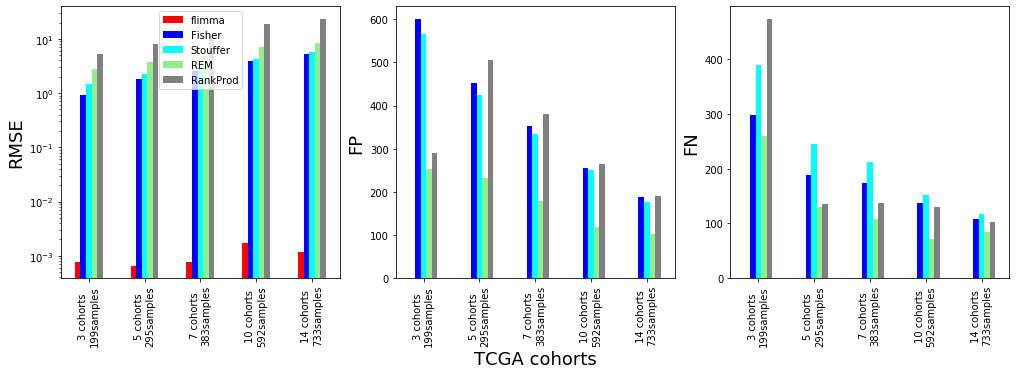

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(17,5), sharey=False)
s = "RMSE"
s2 = "FP"
s3 = "FN"
df = {}
df2 = {}
df3 = {}
colors = ["red","blue","cyan","lightgreen","grey"]
cmap = lcmap(colors, name='from_list', N=None)
for f in tcga_cohorts.keys(): 
    df[f] = tcga_cohorts[f][s]
    df2[f] = tcga_cohorts[f][s2]
    df3[f] = tcga_cohorts[f][s3]
df = pd.DataFrame.from_dict(df).T
tmp = df.plot(kind="bar",ax =axes[0],cmap = cmap)
axes[0].set_ylabel(s,fontsize=18)
axes[0].set_yscale('log')

df2 = pd.DataFrame.from_dict(df2).T
tmp = df2.plot(kind="bar",ax =axes[1],cmap = cmap)
axes[1].set_ylabel(s2,fontsize=18)
axes[1].get_legend().remove()
tmp = axes[1].set_xlabel("TCGA cohorts",fontsize=18)

df3 = pd.DataFrame.from_dict(df3).T
tmp = df3.plot(kind="bar",ax =axes[2],cmap = cmap)
axes[2].set_ylabel(s3,fontsize=18)
axes[2].get_legend().remove()
#tmp = axes[2].set_xlabel("TCGA cohorts",fontsize=18)